In [ ]:
#importing libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, AveragePooling2D, Activation, BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.optimizers import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
print('TF Version:', tf.__version__)

TF Version: 2.4.0


In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Data

In [ ]:
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
#names = ['emotion', 'pixels', 'usage']
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/fer2013.csv', na_filter=False)
im=df['pixels']
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


# Preparing the Dataset

In [ ]:
df.shape

(35887, 3)

In [ ]:
def getData(filename):
    Y = []
    X = []
    first = True
    for line in open(filename):
      if first:
        first = False
      else:
        row = line.split(',')
        Y.append(int(row[0]))
        X.append([int(p) for p in row[1].split()])

    X, Y = np.array(X) / 255.0, np.array(Y)
    return X, Y

In [ ]:
filename = '/content/drive/MyDrive/Colab Notebooks/fer2013.csv'
X, Y = getData(filename)
num_class = len(set(Y))
print('Number of Classes:', num_class)
print(X.shape, Y.shape)
N, D = X.shape
print(N,D)
X = X.reshape(N, 48, 48,1)
print(X.shape)

Number of Classes: 7
(35887, 2304) (35887,)
35887 2304
(35887, 48, 48, 1)


In [ ]:
a = Y[:5, None]
print(a)
b=np.arange(num_class)
print(b)
(b == a).astype(np.float32)

[[0]
 [0]
 [2]
 [4]
 [6]]
[0 1 2 3 4 5 6]


array([[1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [ ]:
#function to plot images
def plot(images, n=5, cmap='gray'):
    for i in range(n*n):
      plt.subplot(n,n,1+i)
      plt.axis('off')
      plt.imshow(images[i, :, :, 0], cmap=cmap)

In [ ]:
#split the dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)

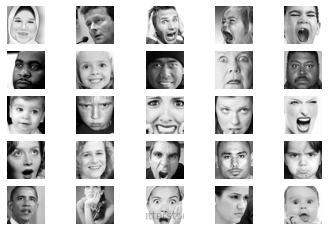

In [ ]:
plot(X_test, 5)

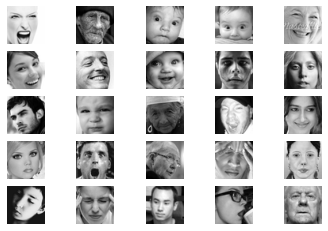

In [ ]:
#creating samples from original data
def create_samples(image_series, n_samples=25):
    samples = image_series[np.random.randint(0, im.shape[0], size=n_samples)]
    samples.reset_index(drop=True, inplace=True)
    X = []
    for i in range(len(samples)):
        X.append([int(p) for p in samples[i].split()])
    samples = np.array(X)
    samples = samples.reshape((n_samples, 48, 48,1))
    return samples

samples = create_samples(im, 25)
plot(samples)

# CNN Model

In [ ]:
def my_model():
    model = Sequential()
    input_shape = (48,48,1)
    model.add(Conv2D(64, (5,5), input_shape=input_shape, activation='relu', padding='same'))
    model.add(Conv2D(64, (5,5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(128, (5,5), activation='relu', padding='same'))
    model.add(Conv2D(128, (5,5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(256, (5,5), activation='relu', padding='same'))
    model.add(Conv2D(256, (5,5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(7))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

    return model

model = my_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       409728    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

In [ ]:
#fit the model
model = my_model()
#K.set_value(model.optimizer.lr, 1e-3)
h = model.fit(x=X_train, y=y_train, 
              batch_size=64, epochs=10, 
              verbose=1, validation_data=(X_test, y_test), shuffle=True)

Epoch 1/10
505/505 [==============================] - 51s 86ms/step - loss: 1.8235 - accuracy: 0.2811 - val_loss: 1.7842 - val_accuracy: 0.3324
Epoch 2/10
505/505 [==============================] - 42s 84ms/step - loss: 1.3991 - accuracy: 0.4577 - val_loss: 1.2598 - val_accuracy: 0.5149
Epoch 3/10
505/505 [==============================] - 42s 84ms/step - loss: 1.1464 - accuracy: 0.5670 - val_loss: 1.1563 - val_accuracy: 0.5595
Epoch 4/10
505/505 [==============================] - 42s 84ms/step - loss: 1.0107 - accuracy: 0.6182 - val_loss: 1.1550 - val_accuracy: 0.5737
Epoch 5/10
505/505 [==============================] - 42s 84ms/step - loss: 0.8742 - accuracy: 0.6770 - val_loss: 1.1314 - val_accuracy: 0.5954
Epoch 6/10
505/505 [==============================] - 42s 84ms/step - loss: 0.7094 - accuracy: 0.7407 - val_loss: 1.1200 - val_accuracy: 0.6152
Epoch 7/10
505/505 [==============================] - 42s 84ms/step - loss: 0.5106 - accuracy: 0.8223 - val_loss: 1.3036 - val_accuracy:

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/emotionDetectionModel.h5')

In [ ]:
objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
y_pos = np.arange(len(objects))
print(y_pos)

[0 1 2 3 4 5 6]


# Predicting the Facial Expression of an Image

In [ ]:
#plotting the bar graph of the predicted probabilities of each class
def plotbargraph(predicted_probabilities):
    objects = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    y_pos = np.arange(len(objects))
    plt.bar(objects, predicted_probabilities, align='center', alpha=0.9)
    plt.title('Emotion')
    plt.show()

In [ ]:
gfg = np.array([1, 2])
print(gfg.shape)

gfg = np.expand_dims(gfg, axis=0)
print(gfg.shape)
print(gfg)

(2,)
(1, 2)
[[1 2]]


In [ ]:
def predict_image(model, img):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255
    result = model.predict(x)
    print(result[0])
    x = np.array(x, 'float32')
    x= x.reshape([48,48])

    plt.gray()
    plt.imshow(img[:,:,0])
    plt.xticks([])
    plt.yticks([])
    plt.show()

    index = np.array(result[0]).argmax()
    objects = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
      
    print('Expression Prediction:',objects[index])
    return result[0]

[8.3972849e-03 4.3342330e-05 1.9584310e-03 4.9377349e-03 7.5497113e-02
 7.8493300e-05 9.0908766e-01]


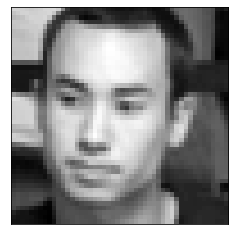

Expression Prediction: Neutral


In [ ]:
predicted_probabilities = predict_image(model, samples[22])

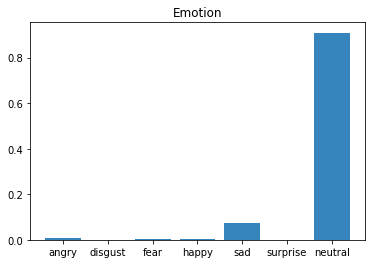

In [ ]:
plotbargraph(predicted_probabilities)

# Assignment-File1

> - Do you get the same results if you run the Notebook multiple time without changing any parameters?
>> - No we don't get the exact same results when we run the notebook multiple times with same parameters. It is good to save the model after training for future use with same performance.

> - What is the effect of adding more neurons to each Conv2D layer?
>> - Adding more neurons to each Conv2D layer increases the accuracy. However, might result in overfitting if we use too many neurons.

> - What happens if we manipulate the value of dropout?
>> - Dropout layer helps to reduce the overfitting. Too less value of dropout won't address the overfitting effectively and too high dropout would result in underfitting. Therefore, due care to be taken while manipulating the dropout values.

> - What is the effect of adding more activation layers to the network?
>> - Adding more activation layers improved the model accuracy.

> - What is the purpose of MaxPooling2D layer?
>> - MaxPooling layer is used to reduce the dimensions of the feature maps. It reduces the number of parameters to be learned and the amount of computation performed in the network. It summarizes the features present in a feature map by selecting the max value feature.

> - Does manipulating the learning rate affect the model? Justify your answer.
>> - Manipulating the learning rate affects the model. Lesser learning rate improves the model accuracy, however, takes more time for execution as the training progesses slowly due to tiny updates to the weights. 